In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# New section

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
! gdown --id 1nBNfV9ZATnde3KDPywwu-LTeIXu0kMbl

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nBNfV9ZATnde3KDPywwu-LTeIXu0kMbl
To: /content/sprints-ai-and-ml-competition-2022 2.zip
100% 264M/264M [00:03<00:00, 80.7MB/s]


In [4]:
!unzip "/content/sprints-ai-and-ml-competition-2022 2.zip" -d "/content/Natural_Competiotion"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/val/buildings/16889.jpg  
  inflating: /content/Natural_Competiotion/__MACOSX/sprints-ai-and-ml-competition-2022/val/buildings/._16889.jpg  
  inflating: /content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/val/buildings/17956.jpg  
  inflating: /content/Natural_Competiotion/__MACOSX/sprints-ai-and-ml-competition-2022/val/buildings/._17956.jpg  
  inflating: /content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/val/buildings/15827.jpg  
  inflating: /content/Natural_Competiotion/__MACOSX/sprints-ai-and-ml-competition-2022/val/buildings/._15827.jpg  
  inflating: /content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/val/buildings/18456.jpg  
  inflating: /content/Natural_Competiotion/__MACOSX/sprints-ai-and-ml-competition-2022/val/buildings/._18456.jpg  
  inflating: /content/Natural_Competiotion/sprints-ai-and-ml-competition-

In [5]:
from torch.utils.data.dataloader import DataLoader

In [6]:
# ! gdown --id 13EB9Dnba40m9dXWEXme7hFAMIib4Eakr

In [7]:
# !unzip "/content/hymenoptera_data.zip" -d "/content/hymenoptera_data"

In [8]:
# os.listdir("/content/hymenoptera_data/hymenoptera_data/train")
train_dir="/content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/train"
val_dir="/content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/val"

In [9]:
train_transform=transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()])
val_transform=transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()])



In [10]:
train_data=torchvision.datasets.ImageFolder(root=train_dir,transform=train_transform)
val_data=torchvision.datasets.ImageFolder(root=val_dir,transform=val_transform)


In [11]:
train_loader=torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=False)
val_loader=torch.utils.data.DataLoader(dataset=val_data,batch_size=32,shuffle=False)


In [12]:
def get_mean_and_std(loader):
  mean=0.
  std=0.
  total_images=0
  for images , _ in loader:
    image_count_in_batch=images.size(0)
    images=images.view(image_count_in_batch, images.size(1),-1)
    mean+=images.mean(2).sum(0)
    std+=images.std(2).sum(0)
    total_images+=image_count_in_batch
  mean /= total_images
  std /= total_images
  return mean ,std   

In [13]:
print(get_mean_and_std(train_loader))
print(get_mean_and_std(val_loader))


(tensor([0.4302, 0.4575, 0.4543]), tensor([0.2362, 0.2345, 0.2433]))
(tensor([0.4300, 0.4575, 0.4523]), tensor([0.2359, 0.2351, 0.2430]))


In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
# transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([ # train pipeline
        transforms.Resize((150,150)),
        #transforms.RandomResizedCrop(125), #bete3mel kaza random crop fe each image , each crop 224x224 
        transforms.RandomHorizontalFlip(),  # flip the images to make the model more robust
        transforms.ToTensor(), # transform the image to tesor so pytorch can read it  
        transforms.Normalize([0.4302, 0.4575, 0.4543],[0.2362, 0.2345, 0.2433]) # first list for mean and second list for std
    ]),
    'val': transforms.Compose([  # validation pipeline
        transforms.Resize((150,150)),   # we need the actual image so we resize it 
        #transforms.CenterCrop(125),                      # center crop to get the actual object you want to classify
        transforms.ToTensor(),
        transforms.Normalize([0.4302, 0.4575, 0.4543], [0.2362, 0.2345, 0.2433]) # one for each colur channel
    ]),
}
# print(data_transforms['val'])

data_dir = "/content/Natural_Competiotion/sprints-ai-and-ml-competition-2022"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# print(image_datasets['val'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4) # shuffle ashan ma3awedsh el model beta3i 3ala pattern mo3ian and to be more robust 
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} #needed for calcualting the loss and accuracy 


class_names = image_datasets['train'].classes

# print(len(image_datasets['val']))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [16]:
print(dataset_sizes["train"],dataset_sizes["val"])


10791 3243


In [17]:
device

device(type='cuda', index=0)

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



In [18]:
def imshow(inp, title=None):    # to visualize some images
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) #load the image.    inp--> image 
    mean = np.array([0.4302, 0.4575, 0.4543])
    std = np.array([0.2362, 0.2345, 0.2433])
    inp = std * inp + mean # to revert the image back to normal otherwise we will get the colur channel all messed uup
    inp = np.clip(inp, 0, 1) # if there is a  value below zero or above 1 --> clip it to zero or 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [19]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [20]:
inputs.shape, classes # (torch.Size([4, 3, 224, 224]).   4--> batch size , 3--> colur chanels RGB   , 224--> image size

(torch.Size([32, 3, 150, 150]),
 tensor([5, 4, 4, 3, 4, 2, 2, 5, 1, 2, 4, 2, 0, 3, 5, 4, 1, 5, 4, 5, 5, 5, 5, 5,
         3, 4, 2, 4, 5, 1, 1, 5]))

In [21]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

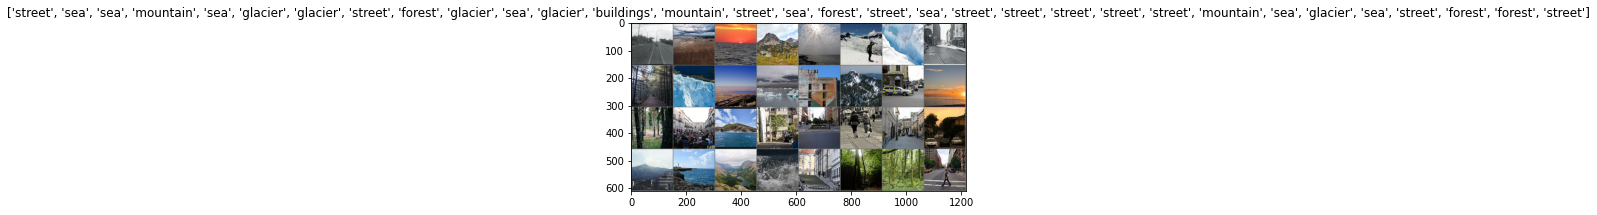

In [22]:
imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # we want to keep  track of time w=so we know how much time it takes to train

    best_model_wts = copy.deepcopy(model.state_dict()) # save the best model at every epoch
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0      # no. of correct classifications

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:    # copy inputs and labels to the gpu
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients

                optimizer.zero_grad()    # DONT FORGET THIS STEP

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # multiply the loss by the batch size
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [24]:
def visualize_model(model, num_images=6): # visualize what the model have learn
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
models.resnet18(pretrained=True)




/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##ResNet 18 Training

In [ ]:
model_ft = models.resnet18(pretrained=True)  # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch

num_ftrs = model_ft.fc.in_features  # no. of feautures in the fully connected layer   

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft.fc = nn.Linear( num_ftrs , 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy
#optim.Ada
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft.parameters()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs

512

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4131 Acc: 0.8571
val Loss: 0.2242 Acc: 0.9269

Epoch 1/24
----------
train Loss: 0.1985 Acc: 0.9323
val Loss: 0.2108 Acc: 0.9260

Epoch 2/24
----------
train Loss: 0.1461 Acc: 0.9520
val Loss: 0.2047 Acc: 0.9319

Epoch 3/24
----------
train Loss: 0.1089 Acc: 0.9615
val Loss: 0.2211 Acc: 0.9303

Epoch 4/24
----------
train Loss: 0.0828 Acc: 0.9738
val Loss: 0.2242 Acc: 0.9297

Epoch 5/24
----------
train Loss: 0.0594 Acc: 0.9810
val Loss: 0.2373 Acc: 0.9337

Epoch 6/24
----------
train Loss: 0.0433 Acc: 0.9867
val Loss: 0.2455 Acc: 0.9291

Epoch 7/24
----------
train Loss: 0.0308 Acc: 0.9918
val Loss: 0.2537 Acc: 0.9334

Epoch 8/24
----------
train Loss: 0.0270 Acc: 0.9922
val Loss: 0.2486 Acc: 0.9328

Epoch 9/24
----------
train Loss: 0.0236 Acc: 0.9947
val Loss: 0.2476 Acc: 0.9319

Epoch 10/24
----------
train Loss: 0.0270 Acc: 0.9938
val Loss: 0.2518 Acc: 0.9300

Epoch 11/24
----------
train Loss: 0.0236 Acc: 0.9952
val Loss: 0.2561 Acc: 0.9315

Ep

In [ ]:
# best accuracy 0.827 batch 32
# ba3d el center crop we tas8eer el batch size best acc=0.9315
#torch.save(model_ft,"/content/resnet18 93.5") #NOTEEEEEEEEEEEEEEEE --> uncomment this if you want to retrain and save 
mod=torch.load("/content/resnet18 93.5")

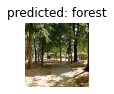

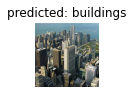

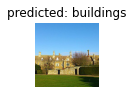

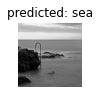

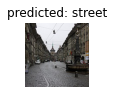

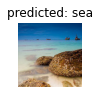

In [ ]:
visualize_model(mod)

##ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False           # freeze layers

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

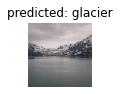

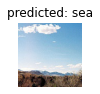

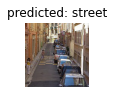

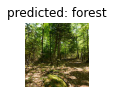

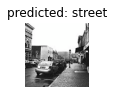

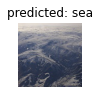

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##Resnet 50 without Freezing

In [ ]:
model_ft = models.resnet50(pretrained=True)  # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch

num_ftrs = model_ft.fc.in_features  # no. of feautures in the fully connected layer   

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft.fc = nn.Linear( num_ftrs , 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)                 

Epoch 0/24
----------
train Loss: 0.3815 Acc: 0.8718
val Loss: 0.1966 Acc: 0.9278

Epoch 1/24
----------
train Loss: 0.1733 Acc: 0.9393
val Loss: 0.1909 Acc: 0.9331

Epoch 2/24
----------
train Loss: 0.1259 Acc: 0.9589
val Loss: 0.1963 Acc: 0.9328

Epoch 3/24
----------
train Loss: 0.0839 Acc: 0.9716
val Loss: 0.2064 Acc: 0.9380

Epoch 4/24
----------
train Loss: 0.0610 Acc: 0.9794
val Loss: 0.2307 Acc: 0.9325

Epoch 5/24
----------
train Loss: 0.0376 Acc: 0.9901
val Loss: 0.2408 Acc: 0.9365

Epoch 6/24
----------
train Loss: 0.0296 Acc: 0.9915
val Loss: 0.2683 Acc: 0.9297

Epoch 7/24
----------
train Loss: 0.0228 Acc: 0.9938
val Loss: 0.2420 Acc: 0.9365

Epoch 8/24
----------
train Loss: 0.0183 Acc: 0.9956
val Loss: 0.2422 Acc: 0.9389

Epoch 9/24
----------
train Loss: 0.0164 Acc: 0.9963
val Loss: 0.2376 Acc: 0.9383

Epoch 10/24
----------
train Loss: 0.0133 Acc: 0.9968
val Loss: 0.2438 Acc: 0.9383

Epoch 11/24
----------
train Loss: 0.0148 Acc: 0.9966
val Loss: 0.2366 Acc: 0.9396

Ep

In [ ]:
#torch.save(model_ft,"/content/resnet50_93.9_or_94.0")
mod2=torch.load("/content/resnet50_93.9_or_94.0")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


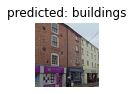

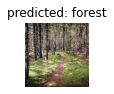

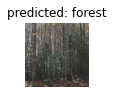

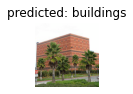

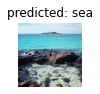

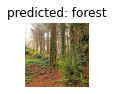

In [ ]:
visualize_model(model_ft)


###Resnet50 With Freezing

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False           # freeze layers

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6915 Acc: 0.7639
val Loss: 0.4302 Acc: 0.8526

Epoch 1/24
----------
train Loss: 0.4839 Acc: 0.8285
val Loss: 0.3557 Acc: 0.8791

Epoch 2/24
----------
train Loss: 0.4598 Acc: 0.8340
val Loss: 0.3499 Acc: 0.8767

Epoch 3/24
----------
train Loss: 0.4511 Acc: 0.8335
val Loss: 0.3523 Acc: 0.8800

Epoch 4/24
----------
train Loss: 0.4328 Acc: 0.8398
val Loss: 0.3347 Acc: 0.8837

Epoch 5/24
----------
train Loss: 0.4279 Acc: 0.8421
val Loss: 0.3305 Acc: 0.8868

Epoch 6/24
----------
train Loss: 0.4160 Acc: 0.8487
val Loss: 0.3110 Acc: 0.8933

Epoch 7/24
----------
train Loss: 0.4065 Acc: 0.8501
val Loss: 0.3167 Acc: 0.8893

Epoch 8/24
----------
train Loss: 0.4217 Acc: 0.8443
val Loss: 0.3179 Acc: 0.8902

Epoch 9/24
----------
train Loss: 0.4020 Acc: 0.8509
val Loss: 0.3095 Acc: 0.8896

Epoch 10/24
----------
train Loss: 0.4114 Acc: 0.8464
val Loss: 0.3145 Acc: 0.8905

Epoch 11/24
----------
train Loss: 0.3987 Acc: 0.8507
val Loss: 0.3130 Acc: 0.8930

Epoch 12/24
----------
t

##Resnet 101 without freezing

In [ ]:
model_ft = models.resnet101(pretrained=True)  # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch

num_ftrs = model_ft.fc.in_features  # no. of feautures in the fully connected layer   

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft.fc = nn.Linear( num_ftrs , 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)  

Epoch 0/24
----------
train Loss: 0.3691 Acc: 0.8756
val Loss: 0.1947 Acc: 0.9328

Epoch 1/24
----------
train Loss: 0.1633 Acc: 0.9435
val Loss: 0.1859 Acc: 0.9352

Epoch 2/24
----------
train Loss: 0.1110 Acc: 0.9604
val Loss: 0.2022 Acc: 0.9315

Epoch 3/24
----------
train Loss: 0.0670 Acc: 0.9787
val Loss: 0.2143 Acc: 0.9349

Epoch 4/24
----------
train Loss: 0.0499 Acc: 0.9842
val Loss: 0.2165 Acc: 0.9389

Epoch 5/24
----------
train Loss: 0.0415 Acc: 0.9880
val Loss: 0.2532 Acc: 0.9306

Epoch 6/24
----------
train Loss: 0.0287 Acc: 0.9914
val Loss: 0.2246 Acc: 0.9365

Epoch 7/24
----------
train Loss: 0.0169 Acc: 0.9950
val Loss: 0.2367 Acc: 0.9396

Epoch 8/24
----------
train Loss: 0.0130 Acc: 0.9980
val Loss: 0.2308 Acc: 0.9377

Epoch 9/24
----------
train Loss: 0.0126 Acc: 0.9971
val Loss: 0.2353 Acc: 0.9386

Epoch 10/24
----------
train Loss: 0.0123 Acc: 0.9969
val Loss: 0.2329 Acc: 0.9377

Epoch 11/24
----------
train Loss: 0.0117 Acc: 0.9975
val Loss: 0.2451 Acc: 0.9362

Ep

In [ ]:
! gdown --id 1Fzpr_pjusAa429gRkSIt8MRZsTcADytD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Fzpr_pjusAa429gRkSIt8MRZsTcADytD
To: /content/resnet101_93.9_94.zip
100% 159M/159M [00:01<00:00, 134MB/s]


note:The next two cells are for loading the saved model (so I can test the model) from google drive because this was quicker than normal drag and drop here in collab.

In [ ]:
!unzip "/content/resnet101_93.9_94.zip" -d "/content"

Archive:  /content/resnet101_93.9_94.zip
  inflating: /content/resnet101_93.9_94.26  


In [ ]:
#torch.save(model_ft,"/content/resnet101_93.9_94.26")
mod3=torch.load("/content/resnet101_93.9_94.26")

###Resnet 101 with freezing

In [ ]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False           # freeze layers

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6728 Acc: 0.7679
val Loss: 0.3726 Acc: 0.8680

Epoch 1/24
----------
train Loss: 0.4639 Acc: 0.8318
val Loss: 0.3702 Acc: 0.8813

Epoch 2/24
----------
train Loss: 0.4510 Acc: 0.8305
val Loss: 0.3265 Acc: 0.8865

Epoch 3/24
----------
train Loss: 0.4290 Acc: 0.8403
val Loss: 0.3576 Acc: 0.8714

Epoch 4/24
----------
train Loss: 0.4287 Acc: 0.8394
val Loss: 0.3640 Acc: 0.8754

Epoch 5/24
----------
train Loss: 0.4170 Acc: 0.8467
val Loss: 0.3361 Acc: 0.8760

Epoch 6/24
----------
train Loss: 0.4137 Acc: 0.8477
val Loss: 0.3374 Acc: 0.8794

Epoch 7/24
----------
train Loss: 0.4059 Acc: 0.8474
val Loss: 0.3300 Acc: 0.8871

Epoch 8/24
----------
train Loss: 0.3964 Acc: 0.8551
val Loss: 0.3098 Acc: 0.8831

Epoch 9/24
----------
train Loss: 0.3948 Acc: 0.8557
val Loss: 0.3133 Acc: 0.8868

Epoch 10/24
----------
train Loss: 0.3940 Acc: 0.8565
val Loss: 0.3063 Acc: 0.8905

Epoch 11/24
----------
train Loss: 0.3981 Acc: 0.8527
val Loss: 0.3106 Acc: 0.8841

Epoch 12/24
----------
t

##VGG19

In [ ]:
model_ft = models.vgg19(pretrained=True)  # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch
last_layer=nn.Linear(4096,6)
model_ft.classifier[6]=last_layer


# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model_ft.classifier[6].parameters()

<generator object Module.parameters at 0x7f50647436d0>

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)  

Epoch 0/24
----------
train Loss: 0.3422 Acc: 0.8772
val Loss: 0.2460 Acc: 0.9090

Epoch 1/24
----------
train Loss: 0.2014 Acc: 0.9295
val Loss: 0.2399 Acc: 0.9180

Epoch 2/24
----------
train Loss: 0.1582 Acc: 0.9438
val Loss: 0.2109 Acc: 0.9312

Epoch 3/24
----------
train Loss: 0.1354 Acc: 0.9518
val Loss: 0.2426 Acc: 0.9229

Epoch 4/24
----------
train Loss: 0.1007 Acc: 0.9654
val Loss: 0.2275 Acc: 0.9278

Epoch 5/24
----------
train Loss: 0.0949 Acc: 0.9657
val Loss: 0.2411 Acc: 0.9266

Epoch 6/24
----------
train Loss: 0.0746 Acc: 0.9752
val Loss: 0.2366 Acc: 0.9309

Epoch 7/24
----------
train Loss: 0.0400 Acc: 0.9867
val Loss: 0.2428 Acc: 0.9343

Epoch 8/24
----------
train Loss: 0.0333 Acc: 0.9888
val Loss: 0.2506 Acc: 0.9356

Epoch 9/24
----------
train Loss: 0.0306 Acc: 0.9901
val Loss: 0.2527 Acc: 0.9356

Epoch 10/24
----------
train Loss: 0.0270 Acc: 0.9915
val Loss: 0.2624 Acc: 0.9334

Epoch 11/24
----------
train Loss: 0.0266 Acc: 0.9913
val Loss: 0.2535 Acc: 0.9365

Ep

In [ ]:
! gdown --id 1Hw1TsrH5GsM7LbEIDy8N59qFfWtoLXC4
!unzip "/content/VGG_93.zip" -d "/content"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Hw1TsrH5GsM7LbEIDy8N59qFfWtoLXC4
To: /content/VGG_93.zip
100% 518M/518M [00:03<00:00, 146MB/s]
Archive:  /content/VGG_93.zip
  inflating: /content/VGG_93.6       


In [ ]:
#torch.save(model_ft,"/content/VGG_93.6")
mod4=torch.load("/content/VGG_93.6")

##Convnext_Small

In [ ]:
model_ft = models.convnext_small(pretrained=True)
model_ft

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


  0%|          | 0.00/192M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [ ]:
model_ft = models.convnext_small(pretrained=True) # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch
last_layer=nn.Linear(768,6)
model_ft.classifier[2]=last_layer


# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)  

Epoch 0/24
----------
train Loss: 0.3523 Acc: 0.8753
val Loss: 0.2432 Acc: 0.9152

Epoch 1/24
----------
train Loss: 0.2051 Acc: 0.9269
val Loss: 0.2116 Acc: 0.9254

Epoch 2/24
----------
train Loss: 0.1754 Acc: 0.9370
val Loss: 0.2081 Acc: 0.9309

Epoch 3/24
----------
train Loss: 0.1634 Acc: 0.9425
val Loss: 0.1997 Acc: 0.9278

Epoch 4/24
----------
train Loss: 0.1465 Acc: 0.9481
val Loss: 0.1805 Acc: 0.9368

Epoch 5/24
----------
train Loss: 0.1318 Acc: 0.9517
val Loss: 0.1831 Acc: 0.9399

Epoch 6/24
----------
train Loss: 0.1191 Acc: 0.9557
val Loss: 0.1803 Acc: 0.9374

Epoch 7/24
----------
train Loss: 0.0927 Acc: 0.9665
val Loss: 0.1712 Acc: 0.9399

Epoch 8/24
----------
train Loss: 0.0853 Acc: 0.9705
val Loss: 0.1725 Acc: 0.9399

Epoch 9/24
----------
train Loss: 0.0828 Acc: 0.9713
val Loss: 0.1756 Acc: 0.9383

Epoch 10/24
----------
train Loss: 0.0806 Acc: 0.9720
val Loss: 0.1718 Acc: 0.9411

Epoch 11/24
----------
train Loss: 0.0774 Acc: 0.9733
val Loss: 0.1802 Acc: 0.9377

Ep

In [ ]:
! gdown --id 1UDkGshEW0EMlEJBZV2VJ-fAC9YcFsmM-
!unzip "/content/ConvNext_Small_94.2_94.zip" -d "/content"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UDkGshEW0EMlEJBZV2VJ-fAC9YcFsmM-
To: /content/ConvNext_Small_94.2_94.zip
100% 184M/184M [00:02<00:00, 81.2MB/s]
Archive:  /content/ConvNext_Small_94.2_94.zip
  inflating: /content/ConvNext_Small_94.2_94.1  


In [ ]:
#torch.save(model_ft,"/content/ConvNext_Small_94.2_94.1")
mod5=torch.load("/content/ConvNext_Small_94.2_94.1")

##MobilNet


In [ ]:
model_ft = models.mobilenet_v3_large(pretrained=True)
model_ft

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
model_ft = models.mobilenet_v3_large(pretrained=True)# you take the trained model with its trained weihts 
last_layer=nn.Linear(1280,6)
model_ft.classifier[3]=last_layer


# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5497 Acc: 0.8167
val Loss: 0.2601 Acc: 0.9112

Epoch 1/24
----------
train Loss: 0.2583 Acc: 0.9102
val Loss: 0.2341 Acc: 0.9183

Epoch 2/24
----------
train Loss: 0.2113 Acc: 0.9255
val Loss: 0.2164 Acc: 0.9254

Epoch 3/24
----------
train Loss: 0.1791 Acc: 0.9370
val Loss: 0.2131 Acc: 0.9285

Epoch 4/24
----------
train Loss: 0.1559 Acc: 0.9456
val Loss: 0.2146 Acc: 0.9288

Epoch 5/24
----------
train Loss: 0.1398 Acc: 0.9517
val Loss: 0.2082 Acc: 0.9334

Epoch 6/24
----------
train Loss: 0.1186 Acc: 0.9573
val Loss: 0.2210 Acc: 0.9285

Epoch 7/24
----------
train Loss: 0.1019 Acc: 0.9657
val Loss: 0.2132 Acc: 0.9291

Epoch 8/24
----------
train Loss: 0.0977 Acc: 0.9675
val Loss: 0.2126 Acc: 0.9288

Epoch 9/24
----------
train Loss: 0.0969 Acc: 0.9666
val Loss: 0.2126 Acc: 0.9288

Epoch 10/24
----------
train Loss: 0.0939 Acc: 0.9671
val Loss: 0.2138 Acc: 0.9291

Epoch 11/24
----------
train Loss: 0.0895 Acc: 0.9689
val Loss: 0.2139 Acc: 0.9278

Ep

In [ ]:
! gdown --id 1tbAkWGTbUruPNnLumwmxBrC0E8NYeVm3
!unzip "/content/MobilNet_Large_93.zip" -d "/content"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1tbAkWGTbUruPNnLumwmxBrC0E8NYeVm3
To: /content/MobilNet_Large_93.zip
100% 15.8M/15.8M [00:00<00:00, 62.6MB/s]
Archive:  /content/MobilNet_Large_93.zip
  inflating: /content/MobilNet_Large_93  


In [ ]:
#torch.save(model_ft,"/content/MobilNet_Large_93")
mod6=torch.load("/content/MobilNet_Large_93")

##RestNet 152

In [ ]:
model_ft = models.resnet152(pretrained=True)
model_ft# you take the trained model with its trained weights 


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model_ft = models.resnet152(pretrained=True)# you take the trained model with its trained weights 
num_ftrs = model_ft.fc.in_features  # no. of feautures in the fully connected layer   


model_ft.fc = nn.Linear( num_ftrs , 6)


# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3754 Acc: 0.8726
val Loss: 0.1860 Acc: 0.9328

Epoch 1/24
----------
train Loss: 0.1620 Acc: 0.9437
val Loss: 0.1888 Acc: 0.9368

Epoch 2/24
----------
train Loss: 0.1044 Acc: 0.9639
val Loss: 0.1909 Acc: 0.9368

Epoch 3/24
----------
train Loss: 0.0639 Acc: 0.9785
val Loss: 0.2595 Acc: 0.9257

Epoch 4/24
----------
train Loss: 0.0448 Acc: 0.9863
val Loss: 0.2283 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.0331 Acc: 0.9904
val Loss: 0.2460 Acc: 0.9337

Epoch 6/24
----------
train Loss: 0.0266 Acc: 0.9915
val Loss: 0.2652 Acc: 0.9309

Epoch 7/24
----------
train Loss: 0.0177 Acc: 0.9948
val Loss: 0.2526 Acc: 0.9377

Epoch 8/24
----------
train Loss: 0.0154 Acc: 0.9962
val Loss: 0.2496 Acc: 0.9371

Epoch 9/24
----------
train Loss: 0.0143 Acc: 0.9969
val Loss: 0.2671 Acc: 0.9337

Epoch 10/24
----------
train Loss: 0.0116 Acc: 0.9976
val Loss: 0.2481 Acc: 0.9377

Epoch 11/24
----------
train Loss: 0.0112 Acc: 0.9979
val Loss: 0.2484 Acc: 0.9402

Ep

In [ ]:
! gdown --id 1ycGPYu4G-M8ruUu1WCA8jBsromWmp-J9
!unzip "/content/Resnet152_93.8_94.zip" -d "/content"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ycGPYu4G-M8ruUu1WCA8jBsromWmp-J9
To: /content/Resnet152_93.8_94.zip
100% 217M/217M [00:01<00:00, 120MB/s]
Archive:  /content/Resnet152_93.8_94.zip
  inflating: /content/Resnet152_93.8_94.0  


In [ ]:
#torch.save(model_ft,"/content/Resnet152_93.8_94.0")
mod7=torch.load("/content/Resnet152_93.8_94.0")

##ConvNext_Tiny

In [ ]:
model_ft = models.convnext_tiny(pretrained=True)
model_ft

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [ ]:
model_ft = models.convnext_tiny(pretrained=True) # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch
last_layer=nn.Linear(768,6)
model_ft.classifier[2]=last_layer


# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3370 Acc: 0.8856
val Loss: 0.2316 Acc: 0.9198

Epoch 1/24
----------
train Loss: 0.2005 Acc: 0.9304
val Loss: 0.2079 Acc: 0.9288

Epoch 2/24
----------
train Loss: 0.1719 Acc: 0.9388
val Loss: 0.2033 Acc: 0.9275

Epoch 3/24
----------
train Loss: 0.1505 Acc: 0.9438
val Loss: 0.1853 Acc: 0.9352

Epoch 4/24
----------
train Loss: 0.1338 Acc: 0.9531
val Loss: 0.1860 Acc: 0.9368

Epoch 5/24
----------
train Loss: 0.1267 Acc: 0.9558
val Loss: 0.1858 Acc: 0.9393

Epoch 6/24
----------
train Loss: 0.1170 Acc: 0.9568
val Loss: 0.1771 Acc: 0.9393

Epoch 7/24
----------
train Loss: 0.0845 Acc: 0.9723
val Loss: 0.1688 Acc: 0.9423

Epoch 8/24
----------
train Loss: 0.0772 Acc: 0.9752
val Loss: 0.1706 Acc: 0.9411

Epoch 9/24
----------
train Loss: 0.0728 Acc: 0.9770
val Loss: 0.1691 Acc: 0.9436

Epoch 10/24
----------
train Loss: 0.0699 Acc: 0.9777
val Loss: 0.1728 Acc: 0.9402

Epoch 11/24
----------
train Loss: 0.0689 Acc: 0.9783
val Loss: 0.1710 Acc: 0.9405

Epoch 12/24
----------
t

In [ ]:
! gdown --id 1VI70Ia_ZMeAks49NtWULadJmY8gHu5r1
!unzip "/content/convNextTiny 94.zip" -d "/content"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1VI70Ia_ZMeAks49NtWULadJmY8gHu5r1
To: /content/convNextTiny 94.zip
100% 103M/103M [00:00<00:00, 107MB/s] 
Archive:  /content/convNextTiny 94.zip
  inflating: /content/convNextTiny 94.3  


In [ ]:
#torch.save(model_ft,"/content/ConvNext_Tiny 94.3")
mod8=torch.load("/content/convNextTiny 94.3")

##ConvNext_Base

In [ ]:
model_ft = models.convnext_base(pretrained=True)
model_ft

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in

In [ ]:
model_ft = models.convnext_base(pretrained=True) # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch
last_layer=nn.Linear(1024,6)
model_ft.classifier[2]=last_layer


# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3849 Acc: 0.8745
val Loss: 0.2310 Acc: 0.9214

Epoch 1/24
----------
train Loss: 0.2165 Acc: 0.9228
val Loss: 0.1984 Acc: 0.9368

Epoch 2/24
----------
train Loss: 0.1877 Acc: 0.9337
val Loss: 0.1874 Acc: 0.9359

Epoch 3/24
----------
train Loss: 0.1642 Acc: 0.9408
val Loss: 0.1835 Acc: 0.9359

Epoch 4/24
----------
train Loss: 0.1496 Acc: 0.9453
val Loss: 0.1857 Acc: 0.9408

Epoch 5/24
----------
train Loss: 0.1423 Acc: 0.9490
val Loss: 0.1884 Acc: 0.9380

Epoch 6/24
----------
train Loss: 0.1302 Acc: 0.9530
val Loss: 0.1838 Acc: 0.9365

Epoch 7/24
----------
train Loss: 0.1087 Acc: 0.9628
val Loss: 0.1736 Acc: 0.9417

Epoch 8/24
----------
train Loss: 0.1040 Acc: 0.9640
val Loss: 0.1747 Acc: 0.9408

Epoch 9/24
----------
train Loss: 0.1018 Acc: 0.9655
val Loss: 0.1780 Acc: 0.9399

Epoch 10/24
----------
train Loss: 0.0998 Acc: 0.9658
val Loss: 0.1770 Acc: 0.9414

Epoch 11/24
----------
train Loss: 0.0975 Acc: 0.9665
val Loss: 0.1771 Acc: 0.9402

Epoch 12/24
----------
t

In [ ]:
torch.save(model_ft,"/content/convNextBase_94.2_94.17")
mod9=torch.load("/content/convNextBase_94.2_94.17")

##ConvNext_Large

In [25]:
model_ft = models.convnext_large(pretrained=True)
model_ft

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in

In [26]:
model_ft = models.convnext_large(pretrained=True) # you take the trained model with its trained weihts 
                                             # if you set to False you will only have architecture of the model and you must train it from scratch
last_layer=nn.Linear(1536,6)
model_ft.classifier[2]=last_layer


# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # play and search for this values to get bets accurarcy

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4437 Acc: 0.8644
val Loss: 0.2302 Acc: 0.9211

Epoch 1/24
----------
train Loss: 0.2181 Acc: 0.9249
val Loss: 0.2100 Acc: 0.9315

Epoch 2/24
----------
train Loss: 0.1850 Acc: 0.9343
val Loss: 0.1918 Acc: 0.9331

Epoch 3/24
----------
train Loss: 0.1705 Acc: 0.9404
val Loss: 0.1803 Acc: 0.9389

Epoch 4/24
----------
train Loss: 0.1581 Acc: 0.9437
val Loss: 0.1881 Acc: 0.9349

Epoch 5/24
----------
train Loss: 0.1477 Acc: 0.9465
val Loss: 0.1794 Acc: 0.9393

Epoch 6/24
----------
train Loss: 0.1365 Acc: 0.9500
val Loss: 0.1745 Acc: 0.9396

Epoch 7/24
----------
train Loss: 0.1186 Acc: 0.9568
val Loss: 0.1695 Acc: 0.9411

Epoch 8/24
----------
train Loss: 0.1140 Acc: 0.9610
val Loss: 0.1732 Acc: 0.9399

Epoch 9/24
----------
train Loss: 0.1100 Acc: 0.9628
val Loss: 0.1717 Acc: 0.9396

Epoch 10/24
----------
train Loss: 0.1088 Acc: 0.9617
val Loss: 0.1744 Acc: 0.9402

Epoch 11/24
----------
train Loss: 0.1082 Acc: 0.9621
val Loss: 0.1736 Acc: 0.9396

Ep

In [29]:
#torch.save(model_ft,"/content/convNextLarge_94.1")
mod10=torch.load("/content/convNextLarge_94.1")

#Post Processing and Testing the model

##Removing extra file "DS_Store" from test file 

In [30]:
test_dir=os.listdir("/content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/test")
print(test_dir)
#we want this format -->/content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/test/22455.jpg
print(len(test_dir))
for i,j in enumerate(test_dir):
  if "DS_Store" in j:
    del test_dir[i]
print(len(test_dir))
    

['22291.jpg', '21734.jpg', '21087.jpg', '23773.jpg', '21437.jpg', '21450.jpg', '23815.jpg', '24290.jpg', '21447.jpg', '740.jpg', '21599.jpg', '20796.jpg', '24106.jpg', '21937.jpg', '21352.jpg', '24220.jpg', '22608.jpg', '21318.jpg', '21423.jpg', '20810.jpg', '22782.jpg', '22237.jpg', '23149.jpg', '23263.jpg', '21231.jpg', '21422.jpg', '21186.jpg', '20093.jpg', '22176.jpg', '22517.jpg', '23312.jpg', '20637.jpg', '22095.jpg', '24154.jpg', '23984.jpg', '21575.jpg', '22412.jpg', '23353.jpg', '21601.jpg', '23978.jpg', '20718.jpg', '21633.jpg', '24096.jpg', '22875.jpg', '20259.jpg', '20240.jpg', '20995.jpg', '21297.jpg', '22290.jpg', '22583.jpg', '24262.jpg', '20099.jpg', '22842.jpg', '23703.jpg', '23032.jpg', '24321.jpg', '21643.jpg', '21813.jpg', '20108.jpg', '21712.jpg', '20493.jpg', '20482.jpg', '23727.jpg', '22208.jpg', '20320.jpg', '21598.jpg', '24007.jpg', '24218.jpg', '23022.jpg', '22774.jpg', '21294.jpg', '20137.jpg', '21498.jpg', '22369.jpg', '20994.jpg', '22045.jpg', '20461.jpg', 

##Data augmentation and normalization for testing

In [31]:
test_transform=transforms.Compose([
        transforms.Resize((150,150)),  
        transforms.ToTensor(), # transform the image to tesor so pytorch can read it  
        transforms.Normalize([0.4302, 0.4575, 0.4543],[0.2362, 0.2345, 0.2433]) ])



##Concatinating whole test image paths  

In [32]:
# classes=class_names
# classes
All_directories=[]
for i in range(len(test_dir)):
    All_directories.append("/content/Natural_Competiotion/sprints-ai-and-ml-competition-2022/test/"+str(test_dir[i]))

In [33]:
classes

tensor([5, 4, 4, 3, 4, 2, 2, 5, 1, 2, 4, 2, 0, 3, 5, 4, 1, 5, 4, 5, 5, 5, 5, 5,
        3, 4, 2, 4, 5, 1, 1, 5])

##Testing the model

In [34]:
import PIL.Image as Image

def predict(model,image_transforms,images_paths,classes):
 lis1=[]
 lis2=[]
 for img_p in images_paths: 
    model=model.eval()
    image=Image.open(img_p)
    image=image_transforms(image).to('cuda').float()
    image=image.unsqueeze(0)

    output=model(image)
    _, predicted=torch.max(output.data,1)

    print(img_p[-9:],predicted.item())
    lis1.append(img_p[-9:])
    lis1.append(predicted.item())
    lis2.append(lis1)
    lis1=[]

 return lis2

In [35]:
 df=predict(mod10,test_transform,All_directories,classes) #mod6 is mobilenet_v3_large
 #We used this cell to predict (Test) all models


22291.jpg 5
21734.jpg 3
21087.jpg 1
23773.jpg 5
21437.jpg 2
21450.jpg 2
23815.jpg 0
24290.jpg 5
21447.jpg 5
t/740.jpg 0
21599.jpg 0
20796.jpg 3
24106.jpg 5
21937.jpg 4
21352.jpg 1
24220.jpg 1
22608.jpg 3
21318.jpg 0
21423.jpg 5
20810.jpg 2
22782.jpg 2
22237.jpg 4
23149.jpg 2
23263.jpg 5
21231.jpg 2
21422.jpg 1
21186.jpg 2
20093.jpg 2
22176.jpg 4
22517.jpg 1
23312.jpg 3
20637.jpg 0
22095.jpg 3
24154.jpg 3
23984.jpg 1
21575.jpg 2
22412.jpg 5
23353.jpg 3
21601.jpg 5
23978.jpg 3
20718.jpg 1
21633.jpg 2
24096.jpg 2
22875.jpg 4
20259.jpg 5
20240.jpg 4
20995.jpg 5
21297.jpg 1
22290.jpg 3
22583.jpg 3
24262.jpg 0
20099.jpg 4
22842.jpg 2
23703.jpg 2
23032.jpg 1
24321.jpg 3
21643.jpg 3
21813.jpg 3
20108.jpg 1
21712.jpg 0
20493.jpg 5
20482.jpg 2
23727.jpg 0
22208.jpg 0
20320.jpg 3
21598.jpg 4
24007.jpg 1
24218.jpg 2
23022.jpg 4
22774.jpg 1
21294.jpg 0
20137.jpg 5
21498.jpg 3
22369.jpg 0
20994.jpg 5
22045.jpg 0
20461.jpg 4
21586.jpg 1
22465.jpg 2
20356.jpg 2
20067.jpg 0
20172.jpg 4
24215.jpg 0
2179

##Saving the model as csv

In [36]:
import pandas as pd   
new_df=pd.DataFrame(df)
new_df.to_csv("ConvNextLarge.csv",index=False)



In [ ]:
type(df)

list

##Reading and merging all csv model results

In [37]:
import pandas as pd   
RN18=pd.read_csv("/content/resnet18.csv")
RN50=pd.read_csv("/content/resnet50.csv")
RN101=pd.read_csv("/content/resnet101.csv")
VGG=pd.read_csv("/content/VGG19.csv")
CN_S=pd.read_csv("/content/ConvNextSmall.csv")
MN=pd.read_csv("/content/MobileNet.csv")
RN152=pd.read_csv("/content/resnet152.csv")
CN_T=pd.read_csv("/content/ConvNextTiny.csv")
CN_B=pd.read_csv("/content/ConvNextBase.csv")
CN_L=pd.read_csv("/content/ConvNextLarge.csv")


# import pandas as pd   
# CN=pd.read_csv("/content/ConvNextSmall.csv")
# MN=pd.read_csv("/content/MobileNet.csv")
# RN18=pd.read_csv("/content/resnet18.csv")
# RN50=pd.read_csv("/content/resnet50.csv")
# RN101=pd.read_csv("/content/resnet101.csv")
# VGG=pd.read_csv("/content/VGG19.csv")
# RN152=pd.read_csv("/content/resnet152.csv")
# #CN_T=pd.read_csv("/content/ConvNextTiny.csv")
# CN_B=pd.read_csv("/content/ConvNextBase.csv")

In [38]:
RN18

,0,1
0,22291.jpg,5
1,21734.jpg,3
2,21087.jpg,1
3,23773.jpg,5
4,21437.jpg,2
...,...,...
3045,23694.jpg,1
3046,23998.jpg,4
3047,21454.jpg,5
3048,22120.jpg,5


In [50]:
l=[RN50,RN101,VGG,CN_S,MN,RN152,CN_T,CN_B,CN_L]
new1=RN18
for i in l:
  new1=pd.merge(new1,i,on="0")




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'1_x'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.


In [51]:
new1.tail(30)
new1

,0,1_x,1_y,1_x,1_y,1_x,1_y,1_x,1_y,1_x,1_y
0,22291.jpg,5,5,5,5,5,5,5,5,5,5
1,21734.jpg,3,3,3,3,3,3,3,3,3,3
2,21087.jpg,1,1,1,1,1,1,1,1,1,1
3,23773.jpg,5,5,5,5,5,5,5,5,5,5
4,21437.jpg,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
3045,23694.jpg,1,1,1,1,1,1,1,1,1,1
3046,23998.jpg,4,4,4,4,4,4,4,4,4,4
3047,21454.jpg,5,5,5,5,5,5,5,5,5,5
3048,22120.jpg,5,5,5,5,5,5,5,5,5,5


In [52]:
new1.shape

(3050, 11)

In [53]:
lis1=new1.iloc[0].to_list()

##Taking the majority voting from all models tested

In [54]:
# n=[1,2,2,2,3,3,4]
# q=new1.iloc[160].to_list()
temp=0
count=0
lis1=[]
lis2=[]
for i in range(new1.shape[0]):
  lis1=new1.iloc[i].to_list()
  x=lis1.pop(0)
  for ele in lis1:
    temp=lis1.count(ele)
    if temp>count:
      count=temp
      var=ele
  lis1=[]
  lis1.append(x)
  lis1.append(var)  
  lis2.append(lis1)
  lis1=[]
  count=0

# print(count,var)

In [55]:
lis2

[['22291.jpg', 5],
 ['21734.jpg', 3],
 ['21087.jpg', 1],
 ['23773.jpg', 5],
 ['21437.jpg', 2],
 ['21450.jpg', 2],
 ['23815.jpg', 0],
 ['24290.jpg', 5],
 ['21447.jpg', 0],
 ['t/740.jpg', 0],
 ['21599.jpg', 0],
 ['20796.jpg', 3],
 ['24106.jpg', 5],
 ['21937.jpg', 4],
 ['21352.jpg', 1],
 ['24220.jpg', 1],
 ['22608.jpg', 3],
 ['21318.jpg', 0],
 ['21423.jpg', 5],
 ['20810.jpg', 2],
 ['22782.jpg', 2],
 ['22237.jpg', 4],
 ['23149.jpg', 2],
 ['23263.jpg', 5],
 ['21231.jpg', 2],
 ['21422.jpg', 1],
 ['21186.jpg', 2],
 ['20093.jpg', 2],
 ['22176.jpg', 4],
 ['22517.jpg', 1],
 ['23312.jpg', 3],
 ['20637.jpg', 0],
 ['22095.jpg', 3],
 ['24154.jpg', 3],
 ['23984.jpg', 1],
 ['21575.jpg', 2],
 ['22412.jpg', 5],
 ['23353.jpg', 3],
 ['21601.jpg', 5],
 ['23978.jpg', 3],
 ['20718.jpg', 1],
 ['21633.jpg', 2],
 ['24096.jpg', 2],
 ['22875.jpg', 4],
 ['20259.jpg', 5],
 ['20240.jpg', 4],
 ['20995.jpg', 5],
 ['21297.jpg', 1],
 ['22290.jpg', 3],
 ['22583.jpg', 3],
 ['24262.jpg', 0],
 ['20099.jpg', 4],
 ['22842.jpg

##Converting the list to data frame

In [56]:
Final_DF=pd.DataFrame(lis2)
Final_DF

,0,1
0,22291.jpg,5
1,21734.jpg,3
2,21087.jpg,1
3,23773.jpg,5
4,21437.jpg,2
...,...,...
3045,23694.jpg,1
3046,23998.jpg,4
3047,21454.jpg,5
3048,22120.jpg,5


In [57]:
Final_DF=Final_DF.sort_values(0)


##Converting data frame to csv file for further post processing in excel
we noticed that we needed to sort the images ascendingly and delete unnecessary text in some images' name. So that the csv file submitted on kaggle is comparable. We have done this in excel by filter and sort tool. Also search and replace for deleting extra unnecessary characters.

In [58]:
Final_DF.to_csv("Final_DF10models.csv")

In [ ]:
Final_DF3=pd.read_csv("/content/Final_DF3.csv")

In [ ]:
Final_DF3

,Image,Label
0,1020.jpg,0
1,1053.jpg,0
2,1081.jpg,0
3,1082.jpg,0
4,20056.jpg,1
...,...,...
3045,920.jpg,0
3046,949.jpg,0
3047,952.jpg,0
3048,961.jpg,0


In [ ]:
Final_DF3=Final_DF3.sort_values("Image")

In [ ]:
Final_DF3


,Image,Label
0,1020.jpg,0
3007,103.jpg,0
1,1053.jpg,0
2,1081.jpg,0
3,1082.jpg,0
...,...,...
3045,920.jpg,0
3046,949.jpg,0
3047,952.jpg,0
3048,961.jpg,0
